In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import rdMolDescriptors
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, metrics


from scipy import interp

In [2]:
inp = pd.read_csv('Total_dataset.csv')
inp

,smiles,toxicity,ref
0,CC1=NN=C(O1)C(=O)NC(C)(C)C2=N/C(=C(/NCC3=CC=C(...,1,DILIrank
1,C1=CC2=C(C=C1OC(F)(F)F)SC(=N2)N,1,DILIrank
2,CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(...,1,DILIrank
3,CC(C1=CC(=CC=C1)OC2=CC=CC=C2)C(=O)O,1,DILIrank
4,CC(=O)NC1=NN=C(S1)S(=O)(=O)N,1,DILIrank
...,...,...,...
1845,c1ccc(cc1)CC2C(=O)NC(C(=O)NC(C(=O)NC(CSSCCC(=O...,0,Liew
1846,CC1C(C(CC(O1)OC2CCC3(C(C2)CCC4C3CC(C5(C4(CCC5C...,0,Liew
1847,COc1cc(cc(c1OC)OC)C(=O)OC2CC3CN4CCc5c6ccccc6[n...,0,Liew
1848,CN(CCCCCCCCCCN(C)C(=O)Oc1cccc(c1)[N+](C)(C)C)C...,0,Liew


In [3]:
inp.groupby('toxicity')['ref'].value_counts()

toxicity  ref     
0         Liew        337
          DILIrank    268
          NCTR        179
          Greene       80
          Xu           34
1         Liew        438
          DILIrank    184
          NCTR        169
          Greene      149
          Xu           12
Name: ref, dtype: int64

In [4]:
train_df = inp.iloc[452:,:].reset_index(drop=True)
train_df

,smiles,toxicity,ref
0,CC(Cc1ccc(c(c1)O)O)(C(=O)O)N,1,NCTR
1,Cc1c(c2ccc(cc2n1CC(=O)O)OC)C(=O)c3ccc(cc3)Cl,1,NCTR
2,CN1C(S(=O)(=O)CCC1=O)c2ccc(cc2)Cl,1,NCTR
3,CC(=O)OC1C(Sc2ccccc2N(C1=O)CCN(C)C)c3ccc(cc3)OC,1,NCTR
4,c1nc2c(n1C3CC(C(O3)CO)O)NC=NCC2O,1,NCTR
...,...,...,...
1393,c1ccc(cc1)CC2C(=O)NC(C(=O)NC(C(=O)NC(CSSCCC(=O...,0,Liew
1394,CC1C(C(CC(O1)OC2CCC3(C(C2)CCC4C3CC(C5(C4(CCC5C...,0,Liew
1395,COc1cc(cc(c1OC)OC)C(=O)OC2CC3CN4CCc5c6ccccc6[n...,0,Liew
1396,CN(CCCCCCCCCCN(C)C(=O)Oc1cccc(c1)[N+](C)(C)C)C...,0,Liew


In [5]:
train_s = train_df.iloc[:,:-1]
train_t = train_df['toxicity']

In [6]:
# smiles 
smiles_list = []
for i in range(len(train_df)):
    train_df['smiles'][i] = str(train_df['smiles'][i])

# tranform smiles to mol 
mols = [Chem.MolFromSmiles(smiles) for smiles in train_df["smiles"]]

# if smiles don't transform to mol, add to non_list
none_list = []
for i in range(len(mols)):
    if mols[i] is None :
        none_list.append(i)
        print('none_list에 추가됨')
    
reg_idx = 0
for i in none_list :
    del mols[i - reg_idx]
    reg_idx += 1
    
# modify index
if len(none_list) != 0 :
    train_df = train_df.drop(none_list, axis=0)
    train_df = train_df.reset_index(drop = True)

C:\Users\llsoy\AppData\Local\Temp\ipykernel_7624\2705748456.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['smiles'][i] = str(train_df['smiles'][i])


In [7]:
train_df['toxicity'].value_counts()

1    768
0    630
Name: toxicity, dtype: int64

In [8]:
# fingerprint 
bit_info_list = [] 
bit_info = {} 
fps = []

b = 0

# mol to fingerprint Bit Vector 
for a in mols :
    fps.append(AllChem.GetMorganFingerprintAsBitVect(a, 3, nBits = 1024, bitInfo = bit_info))
    bit_info_list.append(bit_info.copy())
    
# array 
arr_list = list()
for i in range(len(fps)):
    array = np.zeros((0,), dtype = np.int8)
    arr_list.append(array)
    
for i in range(len(fps)):
    bit = fps[i]
    DataStructs.ConvertToNumpyArray(bit, arr_list[i])
    
x = np.stack([i.tolist() for i in arr_list])
x = x.astype(np.float32)
finprt = pd.DataFrame(x)

In [9]:
# QED properties 

from rdkit.Chem import QED

qe = [QED.properties(mol) for mol in mols]
qe = pd.DataFrame(qe)
train_qe = qe

In [10]:
final = pd.concat([finprt,train_qe,train_t],axis=1)
final

,0,1,2,3,4,5,6,7,8,9,...,1023,MW,ALOGP,HBA,HBD,PSA,ROTB,AROM,ALERTS,toxicity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,211.217,0.44230,5,4,103.78,3,1,1,1
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,357.793,3.92732,4,1,68.53,5,3,1,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,273.741,1.61550,3,0,54.45,1,1,0,1
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,414.527,3.36850,6,0,59.08,6,2,1,1
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,268.273,-0.98900,6,4,112.13,2,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1069.238,-4.34170,16,13,437.91,19,2,4,0
1394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,943.090,0.04230,19,9,282.21,10,0,2,0
1395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,578.662,4.16250,9,1,108.55,7,3,1,0
1396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,556.792,6.76220,4,0,59.08,15,2,2,0


In [11]:
x_train = final.iloc[:,:1032]
y_train = final['toxicity']

## Train set Distribution

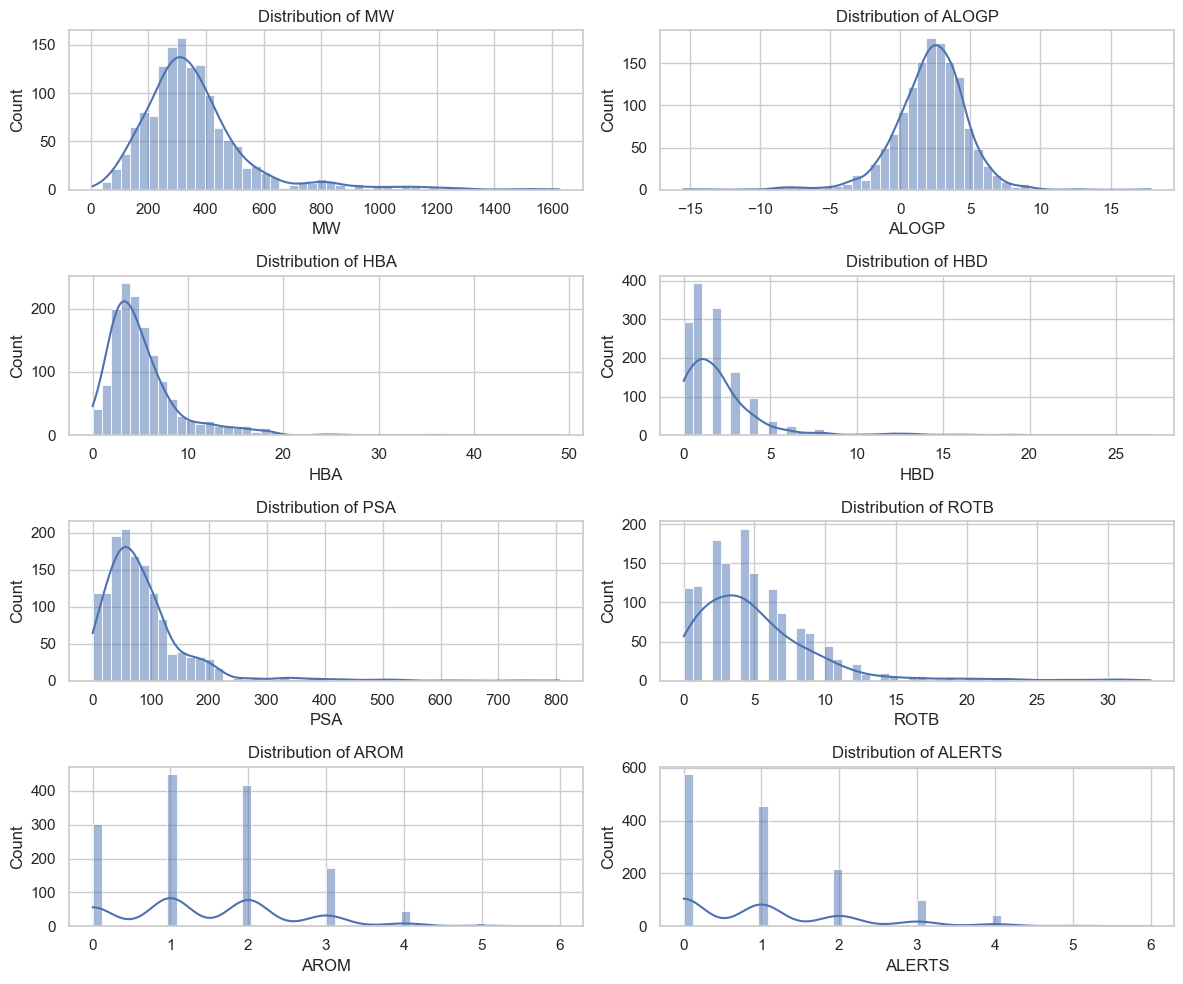

In [12]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 10))

# MW
sns.histplot(train_qe['MW'], kde=True, ax=axes[0,0], bins=50)
axes[0,0].set_title('Distribution of MW')

# ALOGP
sns.histplot(train_qe['ALOGP'], kde=True, ax=axes[0,1], bins=50) 
axes[0,1].set_title('Distribution of ALOGP')

# HBA
sns.histplot(train_qe['HBA'], kde=True, ax=axes[1,0], bins=50) 
axes[1,0].set_title('Distribution of HBA')

# HBD
sns.histplot(train_qe['HBD'], kde=True, ax=axes[1,1], bins=50) 
axes[1,1].set_title('Distribution of HBD')

# PSA
sns.histplot(train_qe['PSA'], kde=True, ax=axes[2,0], bins=50) 
axes[2,0].set_title('Distribution of PSA')

# ROTB
sns.histplot(train_qe['ROTB'], kde=True, ax=axes[2,1], bins=50) 
axes[2,1].set_title('Distribution of ROTB')

# AROM
sns.histplot(train_qe['AROM'], kde=True, ax=axes[3,0], bins=50) 
axes[3,0].set_title('Distribution of AROM')

# ALERTS
sns.histplot(train_qe['ALERTS'], kde=True, ax=axes[3,1], bins=50)
axes[3,1].set_title('Distribution of ALERTS')


plt.tight_layout()
plt.show()

## Applied scaling

In [13]:
from pickle import load 

#QED datapreprocessing 
load_ss = load(open('./DILI_standard_scaler.pkl','rb'))

ss = StandardScaler()

ss.fit(train_qe)
train_sc = ss.transform(train_qe) 
train_sc = pd.DataFrame(train_sc)
train_sc.columns =['MW','ALOGP','HBA','HBD','PSA','ROTB','AROM','ALERTS']
train_sc

C:\Users\llsoy\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


,MW,ALOGP,HBA,HBD,PSA,ROTB,AROM,ALERTS
0,-0.769322,-0.669906,-0.019260,0.733783,0.213807,-0.463486,-0.413202,-0.009528
1,-0.022689,0.682270,-0.266282,-0.435030,-0.237935,-0.034662,1.403327,-0.009528
2,-0.450835,-0.214709,-0.513305,-0.824635,-0.418376,-0.892310,-0.413202,-0.897540
3,0.266304,0.465449,0.227762,-0.824635,-0.359040,0.179750,0.495062,-0.009528
4,-0.478688,-1.225246,0.227762,0.733783,0.320815,-0.677898,-0.413202,-0.897540
...,...,...,...,...,...,...,...,...
1393,3.601285,-2.526083,2.697986,4.240223,4.495807,2.967107,0.495062,2.654509
1394,2.958710,-0.825105,3.439053,2.681805,2.500453,1.037399,-1.321466,0.878484
1395,1.102378,0.773519,0.968830,-0.435030,0.274936,0.394162,1.403327,-0.009528
1396,0.990976,1.782194,-0.266282,-0.824635,-0.359040,2.109459,0.495062,0.878484


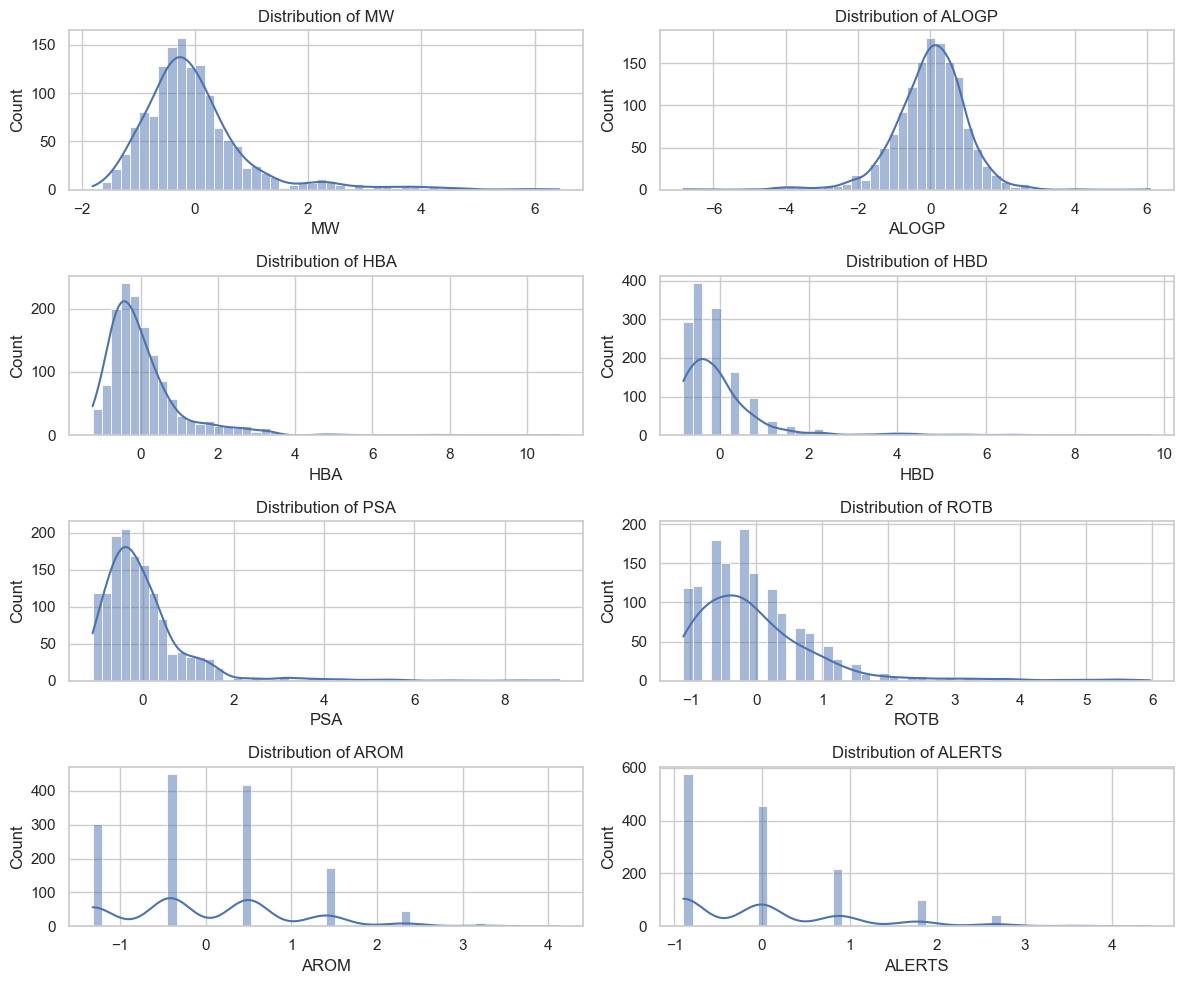

In [14]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 10))

# MW
sns.histplot(train_sc['MW'], kde=True, ax=axes[0,0], bins=50)
axes[0,0].set_title('Distribution of MW')

# ALOGP
sns.histplot(train_sc['ALOGP'], kde=True, ax=axes[0,1], bins=50) 
axes[0,1].set_title('Distribution of ALOGP')

# HBA
sns.histplot(train_sc['HBA'], kde=True, ax=axes[1,0], bins=50)
axes[1,0].set_title('Distribution of HBA')

# HBD
sns.histplot(train_sc['HBD'], kde=True, ax=axes[1,1], bins=50) 
axes[1,1].set_title('Distribution of HBD')

# PSA
sns.histplot(train_sc['PSA'], kde=True, ax=axes[2,0], bins=50) 
axes[2,0].set_title('Distribution of PSA')

# ROTB
sns.histplot(train_sc['ROTB'], kde=True, ax=axes[2,1], bins=50) 
axes[2,1].set_title('Distribution of ROTB')

# AROM
sns.histplot(train_sc['AROM'], kde=True, ax=axes[3,0], bins=50) 
axes[3,0].set_title('Distribution of AROM')

# ALERTS
sns.histplot(train_sc['ALERTS'], kde=True, ax=axes[3,1], bins=50) 
axes[3,1].set_title('Distribution of ALERTS')


plt.tight_layout()
plt.show()

# Molecular substructure

In [15]:
# x_train, x_test
bi_df = x_train.iloc[:,:1024]
bi_df


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
counts = bi_df.apply(lambda x: x.value_counts())
counts_df = pd.DataFrame({'Values of 0': counts.loc[0], 'Values of 1': counts.loc[1]})

counts_df

,Values of 0,Values of 1
0,1323,75
1,923,475
2,1326,72
3,1315,83
4,1161,237
...,...,...
1019,811,587
1020,1344,54
1021,1358,40
1022,1367,31


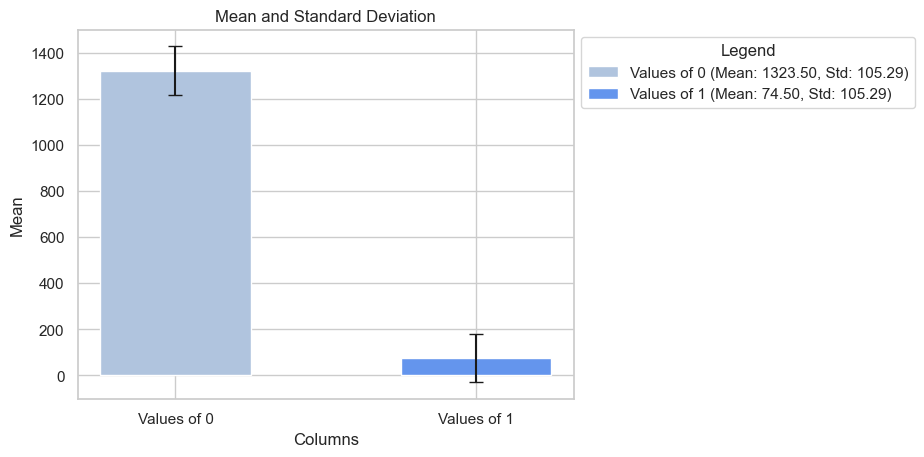

In [17]:
# mean and std 
mean_values = counts_df.mean()
std_values = counts_df.std()

# bar plot
bar_positions = np.arange(len(mean_values))
bar_width = 0.5
plt.bar(bar_positions, mean_values, width=bar_width, yerr=std_values, 
        capsize=5, color=['lightsteelblue', 'cornflowerblue'], label=['Values of 0', 'Values of 1'])

# legend 
legend_labels = [f'{col} (Mean: {mean:.2f}, Std: {std:.2f})' for col, mean, std in zip(mean_values.index, mean_values, std_values)]
plt.legend(labels=legend_labels, loc='upper left', bbox_to_anchor=(1, 1), title='Legend', ncol=1)

# X label
plt.xlabel('Columns')

# Y label
plt.ylabel('Mean')

# graph title 
plt.title('Mean and Standard Deviation')

plt.xticks(bar_positions, mean_values.index)
plt.show()
